# Build trustworthy LLM agents & applications for production with Instructor + Burr

The challenge with large language models (LLMs) is handling the 5% of the time they say crazy things. Being able to debug why an output is bad and having tools for fixing are critical requirements for making LLM features / agents trustworthy and available to users.

In this notebook, you'll learn how `instructor` can make LLM reliability produce structured outputs, and `burr` helps you introspect and debug your application.

## Instructor 101
Instructor is a tool to help you prompt LLM and constraint its outputs. First, you specify the desired output using a **model** with typed fields and textual descriptions; you can think of it as a template that the LLM will fill. This greatly improves the reliability of the content and format of generated text.

To introduce Instructor, we'll write code to generate a social media post from the transcript of a YouTube video. 

> This post on the Instructor blog is also a great introduction: [Analyzing Youtube Transcripts with Instructor](https://python.useinstructor.com/blog/2024/07/11/youtube-transcripts/).

### 1. Define the `response_model`

Instructor uses [Pydantic](https://docs.pydantic.dev/latest/) to create the response model. A model needs to inherit the `BaseModel` class and we use the `Field()` object to give a textual description.

- `Field()` objects allow to specify constraints to the generated output. For instance, we want "1 to 3 concepts" and "1 to 4 key takeaways" generated per `SocialMediaPost`
- Notice that you can nest models. Indeed, `SocialMediaPost.concepts` is a list of `Concept` models.
- We use `SkipJsonSchema` on the `youtube_url` field to specify that this shouldn't be generated by the LLM. Instead, we'll manually pass it.

Tip: We're adding a `.display()` method to format the text to be more easily human-readable. 

In [1]:
import textwrap
from typing import Union

from pydantic import BaseModel, Field
from pydantic.json_schema import SkipJsonSchema

class Concept(BaseModel):
    term: str = Field(description="A key term or concept mentioned.")
    definition: str = Field(description="A brief definition or explanation of the term.")
    timestamp: float = Field(description="Timestamp when the concept is explained.")

    def display(self):
        minutes, seconds = divmod(self.timestamp, 60)
        return f"{int(minutes)}:{int(seconds)} - {self.term}: {self.definition}"


class SocialMediaPost(BaseModel):
    """A social media post about a YouTube video generated its transcript"""

    topic: str = Field(description="Main topic discussed.")
    hook: str = Field(description="Statement to grab the attention of the reader and announce the topic.")
    body: str = Field(description="The body of the social media post. It should be informative and make the reader curious about viewing the video.")
    concepts: list[Concept] = Field(
        description="Important concepts about Hamilton or Burr mentioned in this post.",
        min_items=1,
        max_items=3,
    )
    key_takeaways: list[str] = Field(
        description="A list of informative key takeways for the reader.",
        min_items=1,
        max_items=4,
    )
    youtube_url: SkipJsonSchema[Union[str, None]] = None

    def display(self) -> str:
        formatted_takeways = " ".join([t for t in self.key_takeaways])
        formatted_concepts = "CONCEPTS\n" + "\n".join([c.display() for c in self.concepts])
        link = f"link: {self.youtube_url}\n\n" if self.youtube_url else ""

        return textwrap.dedent(
            f"""\
            TOPIC: {self.topic}

            {self.hook}

            {self.body}

            {formatted_takeways}

            """
        ) + link + formatted_concepts

### 2. Write the application logic

Instructor is not opiniated about how you write your application; it's only in contact with your LLM client. Here, we write a script in a few lines of code to retrieve a YouTube transcript.

In [2]:
from youtube_transcript_api import YouTubeTranscriptApi

# get the video id from a YouTube url
youtube_url = "https://www.youtube.com/watch?v=hqutVJyd3TI" 
_, _, video_id = youtube_url.partition("?v=")

# get the available YouTube transcript for the video
transcript = YouTubeTranscriptApi.get_transcript(video_id)
# join the transcript into a single block of text
full_transcript = " ".join([f"ts={entry['start']} - {entry['text']}" for entry in transcript])

### Wrap the LLM client
To use Instructor, we need to wrap the OpenAI client, creating a special client. 

> NOTE: If you have the environment variable `OPENAI_API_KEY` set, the client will be automatically created. Otherwise, you'll need to manually pass the key to `OpenAI(api_key=...)`.

In [3]:
import instructor
from openai import OpenAI

llm_client = instructor.from_openai(OpenAI())

#### Use the LLM client with the `response_model`

1. Use the LLM client with `.create` to call the LLM API
2. Pass `SocialMediaPost` as the response model, enabling structured outputs.
3. The `messages` include the `system` message with the task instruction for the LLM and
the `user` message with the input content. 

In [4]:
response = llm_client.chat.completions.create(
    model="gpt-4o-mini",
    response_model=SocialMediaPost,
    messages=[
        {
            "role": "system",
            "content": "Analyze the given YouTube transcript and generate a compelling social media post.",
        },
        {"role": "user", "content": full_transcript},
    ],
)

`response` will have the type of the provided `response_model`, `SocialMediaPost` in this case. You can use `Model.model_dump()` to get a Python dictionary.

In [5]:
print(type(response))
print(response.model_dump())

<class '__main__.SocialMediaPost'>
{'topic': 'Agent Development and Debugging', 'hook': 'Ever faced challenges while developing AI agents? Fixing bugs can be a nightmare!', 'body': 'Join us in our latest video where we dive into the tools and techniques that can streamline your agent development, especially when things go off the rails. Discover the functionalities of Burr, a framework designed to help debug your agent applications without starting from scratch. From creating flowcharts to tracking your state, learn how to build and monitor your agent’s performance effectively!', 'concepts': [{'term': 'Burr Framework', 'definition': 'A framework that helps in building and debugging agent applications by modeling actions and states in a graph structure.', 'timestamp': 83.0}, {'term': 'Local Tracker', 'definition': 'A feature that allows you to initialize from a previous state and track or introspect the running application.', 'timestamp': 260.0}, {'term': 'Graph Structure', 'definition'

We can also use the `.display()` method we've defined!

In [7]:
print(response.display())

TOPIC: Agent Development and Debugging

Ever faced challenges while developing AI agents? Fixing bugs can be a nightmare!

Join us in our latest video where we dive into the tools and techniques that can streamline your agent development, especially when things go off the rails. Discover the functionalities of Burr, a framework designed to help debug your agent applications without starting from scratch. From creating flowcharts to tracking your state, learn how to build and monitor your agent’s performance effectively!

Streamline your AI agent debugging process. Utilize the Burr framework to manage states and actions effectively. Learn to visualize and control your agent's behavior through graph structures.

CONCEPTS
1:23 - Burr Framework: A framework that helps in building and debugging agent applications by modeling actions and states in a graph structure.
4:20 - Local Tracker: A feature that allows you to initialize from a previous state and track or introspect the running applica

## Burr 101
Burr is a tool to build LLM applications, solving many challenges to get to production (monitoring, persistence, streaming, and more). With the concepts of "state" and "action", you can define complex apps that are easy-to-understand and debug.

To show this, we'll rewrite the previous application logic with Burr.

### 1. Define `actions`

First, you need to define the different actions your agent can take. This is done by writing Python functions with the `@action` decorator. The decorator must specify the information that can be read from state. Also, the function needs to take a `State` object as first argument and return a `State` object.

In [8]:
from burr.core import State, action


@action(reads=[], writes=["transcript"])
def get_youtube_transcript(state: State, youtube_url: str) -> State:
    """Get the official YouTube transcript for a video given it's URL"""
    _, _, video_id = youtube_url.partition("?v=")
    
    transcript = YouTubeTranscriptApi.get_transcript(video_id, languages=["en"])
    full_transcript = " ".join([f"ts={entry['start']} - {entry['text']}" for entry in transcript])

    # store the transcript in state
    return state.update(transcript=full_transcript, youtube_url=youtube_url)


@action(reads=["transcript"], writes=["post"])
def generate_post(state: State, llm_client) -> State:
    """Use the Instructor LLM client to generate `SocialMediaPost` from the YouTube transcript."""

    # read the transcript from state
    transcript = state["transcript"]

    response = llm_client.chat.completions.create(
        model="gpt-4o-mini",
        response_model=SocialMediaPost,
        messages=[
            {
                "role": "system",
                "content": "Analyze the given YouTube transcript and generate a compelling social media post.",
            },
            {"role": "user", "content": transcript},
        ],
    )

    # add the youtube_url found in state to the SocialMediaPost
    response.youtube_url = state["youtube_url"]

    # store the chapters in state
    return state.update(post=response)

### 2. Assemble the `Application`

To create a Burr agent, we need to assemble the `actions` into an `Application`. This requires specifying the valid `transitions` between actions using tuples of action names `(from, to)` and defining an `entrypoint` from where to begin execution. Then, we can visualize the graph of possible states and actions.

Notice that we create the Instructor LLM client *outside* the application and pass it to the `generate_chapters` action via the `.bind()` method. This method follows the same logic as the standard library `functools.partial()`.

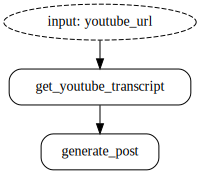

In [9]:
from burr.core import ApplicationBuilder

application = (
    ApplicationBuilder()
    .with_actions(
        get_youtube_transcript,
        generate_post.bind(llm_client=llm_client),
    )
    .with_transitions(
        ("get_youtube_transcript", "generate_post"),
    )
    .with_entrypoint("get_youtube_transcript")
    .build()
)
application.visualize()

### 3. Launch the application

Using `application.run()` will make our application iterate through actions and state until it hits a `halt` condition. Here, we will simply halt after completing the `generate_post` action. This will return a tuple of (the last action take, the result of the last action, the state of the app). We also need to pass a `youtube_url` since it's a required input to the `get_youtube_transcript` action.

In [10]:
last_action, result, state = application.run(
    halt_after=["generate_post"],
    inputs={"youtube_url": "https://www.youtube.com/watch?v=hqutVJyd3TI"},
)

# print `post` stored in state
print(state["post"].display())

TOPIC: Burr Framework for Agent Applications

Unlock the potential of your AI agents with Burr!

Ever faced frustrating failures when building your AI agent applications? Explore how the Burr framework provides robust observability and state management that lets you debug effectively and even revisit previous states. Learn how you can create dynamic action graphs that not only streamline your Dev Loop but also help you track and fix errors without starting from scratch! Dive into our latest video to see Burr in action and discover how it can revolutionize your agent-building process!

Burr enables dynamic action modeling and enhances state management. Debugging is simplified by tracking actions over time and allowing state forking. You can run applications seamlessly without starting from scratch after adjustments.

link: https://www.youtube.com/watch?v=hqutVJyd3TI

CONCEPTS
2:25 - State Management: A method to handle state data within applications, crucial for debugging and managing a

## Why create a Burr application?

In a few lines of code, you can query an LLM API and can create powerful productivity utilities. However, user-facing features deserve much more scrutiny, which requires tooling and solving complex engineering problems.

Building our app with Burr provides several benefits that we'll detail next:
- **Observability**: monitor in real-time and log the execution of your `Application` and view it in Burr's web user interface.
- **Persistence**: At any point, you can save the application `State`. This allows to create user sessions (e.g., the conversation history menu in ChatGPT), which helps developers investigate bugs and test potential solutions.
- **Portability**: your `Application` can run in a notebook, as a script, as a web service, or anywhere Python runs. We'll show how to use Burr with [FastAPI](https://fastapi.tiangolo.com/).

### 1. Observability

Add the clause `.with_tracker(project=...)` to the `ApplicationBuilder()` to track execution. 


In [11]:
from burr.core import ApplicationBuilder

application = (
    ApplicationBuilder()
    .with_actions(
        get_youtube_transcript,
        generate_post.bind(llm_client=llm_client),
    )
    .with_transitions(
        ("get_youtube_transcript", "generate_post"),
    )
    .with_entrypoint("get_youtube_transcript")
    .with_tracker(project="youtube-post")
    .build()
)

In [ ]:
last_action, result, state = application.run(
    halt_after=["generate_post"],
    inputs={"youtube_url": "https://www.youtube.com/watch?v=hqutVJyd3TI"},
)

Then, you can launch the web UI via the CLI command `burr`

### 2. Persistence

To showcase this feature, we'll add a `rewrite()` action. It sends to the LLM the social media post and a user input to tweak its content. 

In [12]:
@action(reads=["post"], writes=["post"])
def rewrite_post(state: State, llm_client, user_prompt: str):
    post = state["post"]

    response = llm_client.chat.completions.create(
        model="gpt-4o-mini",
        response_model=SocialMediaPost,
        messages=[
            {
                "role": "system",
                "content": f"Take the previously generated social media post and modify it according to the following instructions: {user_prompt}",
            },
            {"role": "user", "content": post.model_dump_json()},
        ],
    )

    # pass the youtube_url from the previous post version
    response.youtube_url = post.youtube_url

    return state.update(post=response)

By adding the transition `("rewrite_post", "rewrite_post")`, we are introducing a graph cycle. Observability and persistence becomes particularly valuable to ensure that the LLM doesn't spiral into non-sense. If that's the case, it could be due to the prompts / instructions in the application code, but also user inputs.

We also add a `.with_persister()` clause to store our results

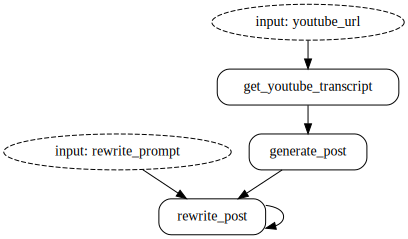

In [26]:
from burr.core import ApplicationBuilder
from burr.core.persistence import SQLLitePersister

application = (
    ApplicationBuilder()
    .with_actions(
        get_youtube_transcript,
        generate_post.bind(llm_client=llm_client),
        rewrite_post.bind(llm_client=llm_client),
    )
    .with_transitions(
        ("get_youtube_transcript", "generate_post"),
        ("generate_post", "rewrite_post"),
        ("rewrite_post", "rewrite_post"),
    )
    .with_state_persister(
        SQLLitePersister(db_path=".burr.db", table_name="state")
    )
    .with_entrypoint("get_youtube_transcript")
    .with_tracker(project="youtube-post")
    .build()
)
application.visualize(output_file_path="statemachine.png")

In [23]:
# this will run 
last_action, result, state = application.run(
    halt_after=["generate_post"],
    inputs={"youtube_url": "https://www.youtube.com/watch?v=hqutVJyd3TI"},
)
print("LAST ACTION :", last_action, "\n")
print(state["post"].display())

LAST ACTION : generate_post: transcript -> post 

TOPIC: Debugging and Observability in Agent Applications with Burr

🚀 Struggling to debug your AI agent? Meet Burr!

In this video, we dive into how Burr can transform your debugging experience for AI agents. Discover how it helps you monitor, debug, and handle errors without starting from scratch. With its unique approach to state management and action modeling, Burr simplifies navigating through failures and understanding your code's behavior. Let's explore the power of visualizing your application as a graph and how you can seamlessly fix issues without losing your progress! 🎥✨

Burr offers an innovative way to visualize action flows in AI agents. Debugging becomes easier by allowing developers to fix bugs without restarting the whole application. Explore how using a state object facilitates communication between different actions in your code.

link: https://www.youtube.com/watch?v=hqutVJyd3TI

CONCEPTS
2:25 - State Object: A state 

In [24]:
last_action, result, state = application.step(
    inputs={"user_prompt": "Adopt a professional tone that avoids incredible claims. Stay close to the facts, but demonstrate enthusiasm"},
)

print("LAST ACTION :", last_action, "\n")
print(state["post"].display())

LAST ACTION : rewrite_post: post -> post 

TOPIC: Debugging and Observability in Agent Applications with Burr

🚀 Struggling to debug your AI agent? Meet Burr!

In this informative video, we explore how Burr can enhance your debugging experience for AI agents. Learn about its capabilities in monitoring, debugging, and managing errors without the need to start from scratch. Discover the role of state management and action modeling in simplifying the navigation through failures and understanding your code's behavior. We will also discuss how visualizing your application as a graph can help in seamlessly addressing issues while retaining progress. Click the link to learn more! 🎥✨

Burr offers an innovative way to visualize action flows in AI agents. Debugging becomes easier by allowing developers to fix bugs without restarting the whole application. Explore how using a state object facilitates communication between different actions in your code.

CONCEPTS
2:25 - State Object: A state obje

### 3. Portability

In the GitHub repository, you can find the same Burr `Application` defined in `application.py`, which can be executed via `python application.py`. Also, we provide a boilerplate FastAPI application in `server.py` which imports the `Application` defined in `application.py`